In [1]:
# import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
np.random.seed(1)

# load the data
#Adjusted close price is the closing price after adjustments for all applicable splits and dividend distributions
AAPL_prices = pd.read_csv("AAPL.csv", usecols=["Adj Close"]) 
AAPL_returns = np.log(AAPL_prices['Adj Close']).diff()[1:] # delete the first row which is nan
SOL_prices = pd.read_csv("SOL.csv", usecols=["Adj Close"]) 
SOL_returns = np.log(SOL_prices['Adj Close']).diff()[1:] # delete the first row which is nan
SOL_returns

1      -0.041493
2       0.030699
3       0.056512
4      -0.014017
5      -0.063647
          ...   
3327   -0.052380
3328   -0.017311
3329    0.086914
3330   -0.004278
3331    0.080290
Name: Adj Close, Length: 3331, dtype: float64

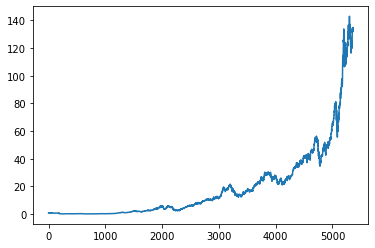

In [2]:
plt.plot(AAPL_prices)

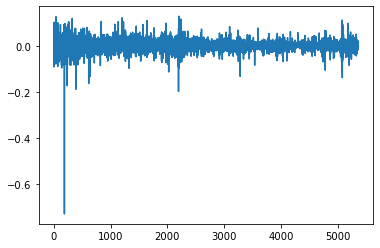

In [3]:
plt.plot(AAPL_returns)

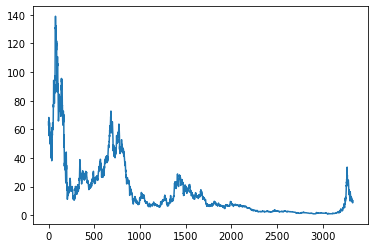

In [4]:
plt.plot(SOL_prices)

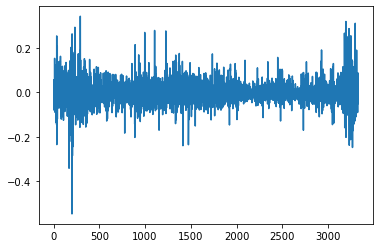

In [5]:
plt.plot(SOL_returns)

## Environment

In [106]:
# actions
buy = 1
sell = -1
actions = [buy, sell]

# Parameters
K = 5
eta = 0.05
initial_investment = 5000

def random_policy(actions):
    return np.random.choice(actions)

def epsilon_greedy_policy(epsilon, actions, values):
    if np.random.binomial(1, epsilon) == 1:
        return np.random.choice(actions)
    else:
        argmax = np.argmax(values)
        return actions[argmax]


class TradingSystem:
    def __init__(self, stock_returns, k_value, eta, initial_investment):
        self.initial_investment = initial_investment
        self.capital = self.initial_investment
        self.k = k_value
        self.eta = eta
        self.r_ts = stock_returns
        self.total_steps = len(self.r_ts) - self.k
        self.current_step = 0
        self.initial_state = tuple(self.r_ts[:self.k].tolist()+[random_policy(actions)]) # Use tuple because it's immutable
        self.state = self.initial_state
        self.reward = 0.0
        self.daily_returns = []
        self.at = 0.0
        self.bt = 0.0
        self.is_terminal = False

    # write step function that returns obs(next state), reward, is_done
    def step(self, action):
        self.current_step += 1
        if self.current_step == self.total_steps:
             self.is_terminal = True
        gainOrloss = self.capital*action*self.r_ts[self.current_step+self.k-1]
        obtained_return = action*self.r_ts[self.current_step+self.k-1]
        self.capital += gainOrloss
        self.daily_returns.append(gainOrloss)
        delta_at =  gainOrloss - self.at
        delta_bt =  gainOrloss**2 - self.bt
        numerator = self.bt*delta_at - 0.5*self.at*delta_bt
        denominator = (self.bt - self.at**2)**1.5
        self.reward = obtained_return
        self.at += self.eta*delta_at
        self.bt += self.eta*delta_bt
        self.state = tuple(self.r_ts[self.current_step:(self.k+self.current_step)].tolist()+[action])
        return self.state, self.reward, self.is_terminal

    def get_profit(self):
        return self.capital - self.initial_investment
    
    def get_daily_returns(self):
        return self.daily_returns
    
    def reset(self):
        self.state = self.initial_state
        self.reward = 0.0
        self.daily_returns = []
        self.current_step = 0
        self.capital = self.initial_investment
        self.at = 0.0
        self.bt = 0.0
        self.is_terminal = False
        return self.state


In [7]:
class DiscountedApproximator:
    def __init__(self, dim, n_a, alpha, discount):
        self.__discount = discount
        self.__alpha = alpha
        self.__n_actions = n_a
        self.__feature_dim = dim
        self.__w_size = self.__feature_dim + 1 # add the bias term
        self.__w = np.zeros(self.__w_size)

    def get_w(self):
        return self.__w
    
    def reset_w(self):
        self.__w = np.zeros(self.__w_size)

    def squashing_f(self, x):
        a = 2
        b = 1
        c = 10**15
        d = -1
        return a/(math.exp(-c*x)*b+1)-d
    
    
    def feature_transformation(self, state, a):
        features = np.array([1] + list(state) + [a])
        return features

    # linear_features
    def action_value_estimator(self, features):
        return np.inner(features, self.__w)

    # minimising MSE between q(replaced by td target) and q_hat
    def update_w(self, r, q, next_q, features):
        target = r + self.__discount * next_q
        td_error = target - q
        w_gradient = self.__alpha * td_error * features
        self.__w = self.__w + w_gradient
    

    def cost_to_go(self, state):
        features = self.feature_transformation(state)
        v_s = []
        for i in range(self.__n_actions):
            v_s.append(self.action_value_estimator(features, i))
        return - np.max(v_s)


In [8]:
class ContinuingApproximator:
    def __init__(self, dim, n_a, alpha, beta):
        self.__alpha = alpha
        self.__beta = beta
        self.__n_actions = n_a
        self.__feature_dim = dim
        self.__average_reward = 0
        self.__w_size = self.__feature_dim + 1 # add the bias term
        self.__w = np.zeros(self.__w_size)

    def get_w(self):
        return self.__w
    
    def reset_w(self):
        self.__w = np.zeros(self.__w_size)

    def feature_transformation(self, state, a):
        features = np.array([1] + list(state) + [a])
        return features

    # linear_features
    def action_value_estimator(self, features):
        return np.inner(features, self.__w)

    # minimising MSE between q(replaced by td target) and q_hat
    def update_w(self, r, q, next_q, features):
        target = r - self.__average_reward + next_q
        td_error = target - q
        self.__average_reward += self.__beta*td_error
        w_gradient = self.__alpha * td_error * features
        self.__w = self.__w + w_gradient

    def cost_to_go(self, state):
        features = self.feature_transformation(state)
        v_s = []
        for i in range(self.__n_actions):
            v_s.append(self.action_value_estimator(features, i))
        return - np.max(v_s)
    


In [9]:
#SARSA algorithm
def SARSA(env, actions, epsilon, estimator):
    state = env.reset()
    estimator.reset_w()
    a = random_policy(actions)
    while True:
        next_state, r, done= env.step(a) 
        if done:
            break
        # compute q_sa
        features = estimator.feature_transformation(state, a)
        q_sa = estimator.action_value_estimator(features)

        # compute all actions in the next state for optimal policy
        q_values = []
        for j in actions:
            next_feature = estimator.feature_transformation(next_state, j)
            q_values.append(estimator.action_value_estimator(next_feature))

        next_a = epsilon_greedy_policy(epsilon, actions, q_values)
        # SARSA updates the action-value using the value of the action generated from the policy
        next_q_sa = q_values[actions.index(next_a)]

        # update weights for current action
        estimator.update_w(r, q_sa, next_q_sa, features)
        a = next_a
        state = next_state
        
    final_profit = env.get_profit()
    dr = env.get_daily_returns()
    positive_pc = len()
    weights = estimator.get_w()
    return final_profit, dr, weights



# Q-learning algorithm
def Q_learning(env, actions, epsilon, estimator):
    state = env.reset()
    estimator.reset_w()
    a = random_policy(actions)
    while True:
        next_state, r, done= env.step(a) 
        if done:
            break
        # compute q_sa
        features = estimator.feature_transformation(state, a)
        q_sa = estimator.action_value_estimator(features)

        # compute all actions in the next state for optimal policy
        q_values = []
        for j in actions:
            next_feature = estimator.feature_transformation(next_state, j)
            q_values.append(estimator.action_value_estimator(next_feature))

        next_a = epsilon_greedy_policy(epsilon, actions, q_values)
        # q-learning updates the action-value using the value of the action maximizing it
        next_q_sa = np.max(q_values)

        # update weights for current action
        estimator.update_w(r, q_sa, next_q_sa, features)
        a = next_a
        state = next_state
        
    final_profit = env.get_profit()
    dr = env.get_daily_returns()
    weights = estimator.get_w()
    return final_profit, dr, weights

In [145]:
# Discounted Tasks
env = TradingSystem(SOL_returns, K, eta, initial_investment)
n_actions = len(actions)
alpha = 0.05
gamma = 0.95
epsilon = 0.1
dim = K + 2
estimator = DiscountedApproximator(dim, n_actions, alpha, gamma)

profit_s, dr_s, weights_s = SARSA(env, actions, epsilon, estimator)
profit_q, dr_q, weights_q = Q_learning(env, actions, epsilon, estimator)


print("Final profit for SARSA: ", profit_s)
print("Final profit for Q-Learning: ", profit_q)

Final profit for SARSA:  -4922.279669478834
Final profit for Q-Learning:  -4988.2621129030895


In [148]:
weights_s

array([ 0.00258793, -0.00277698,  0.0011373 , -0.00169584, -0.00071217,
        0.01032052,  0.00144507,  0.00264807])

In [158]:
# Continuing tasks
env = TradingSystem(AAPL_returns, K, eta, initial_investment)
n_actions = len(actions)
alpha = 0.05
beta = 0.05
epsilon = 0.1
dim = K + 2
estimator = ContinuingApproximator(dim, n_actions, alpha, beta)

profit_s, dr_s, weights_s = SARSA(env, actions, epsilon, estimator)
profit_q, dr_q, weights_q = Q_learning(env, actions, epsilon, estimator)

print("Final profit for SARSA: ", profit_s)
print("Final profit for Q-Learning: ", profit_q)

Final profit for SARSA:  -2634.250320527198
Final profit for Q-Learning:  -2509.5049852972093


In [37]:
weights_s

array([-0.21834914, -0.00655116,  1.17989479,  1.03167078,  0.45923707,
       -0.57139336,  0.12562426,  0.22386692])